# Deterministic Pursuit-Only Dynamics

- The predator accelerates in a straight line towards the prey
- The predator has higher speed than the prey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import math

## Parameters

In [26]:
params = {
    "dt": 0.001,
    
    "x1_max": 1,
    "y1_max": 3,
    
    "x2_max": 3,
    "y2_max": 1,
    
    "R_kill": 1,
    "R_react": 2,
}

params['n_steps'] = round(100 / params['dt'])

## Starting conditions

In [ ]:
# time: t in {0, ... n_steps}
# agents: 0=predator, 1=prey;
# feature: 0=x, 1=x',2=x'' 
# dims 2D

def get_trajectory(deg: float):
    
    state = np.zeros((params['n_steps'], 2, 3, 2), dtype=float)

    # initial predator pos, vel, acc
    state[0, 0, 0] = [0, 0] 
    state[0, 0, 1] = [0, 0] 
    state[0, 0, 2] = [0, 0] 

    rad = np.deg2rad(deg) 

    # initial prey pos, vel, acc
    state[0, 1, 0] = [2, 2]
    state[0, 1, 1] = [np.sin(rad) * params['x1_max'], np.cos(rad) * params['x1_max']]
    state[0, 1, 2] = [0, 0] 
    
    return state

In [4]:
def normalize(v):
    length = np.linalg.norm(v)
    if length == 0:
        return np.zeros_like(v)
    return v / length

def rotate_right_90(v):
    """Rotate a 2D vector 90 degrees to the right (clockwise)."""
    return np.array([v[1], -v[0]])

def step(state, t, dt, y1_max, x1_max):
    """
    Update position and velocity for timestep t based on previous state.
    Applies max speed limits separately for predator (agent 0) and prey (agent 1).
    """
    # Position update
    state[t, :, 0, :] = state[t-1, :, 0, :] + state[t-1, :, 1, :] * dt

    # Velocity update
    state[t, :, 1, :] = state[t-1, :, 1, :] + state[t-1, :, 2, :] * dt

    # Limit predator speed
    pred_speed = np.linalg.norm(state[t, 0, 1, :])
    if pred_speed > x1_max:
        state[t, 0, 1, :] = state[t, 0, 1, :] / pred_speed * x1_max

    # Limit prey speed
    prey_speed = np.linalg.norm(state[t, 1, 1, :])
    if prey_speed > y1_max:
        state[t, 1, 1, :] = state[t, 1, 1, :] / prey_speed * y1_max

    return state


In [28]:
def simulate(state, params):
    """
    Run the simulation and return the final state tensor.
    state: (n_steps, 2 agents, 3 features, 2 dims)
    params: dictionary containing simulation parameters
    """
    n_steps = state.shape[0]
    dt = params["dt"]
    y1_max = params["y1_max"]
    x1_max = params["x1_max"]
    y2_max = params["y2_max"]
    x2_max = params["x2_max"]
    r_kill = params["R_kill"]
    r_react = params["R_react"]

    for t in range(1, n_steps):
        distance = np.linalg.norm(state[t-1, 0, 0] - state[t-1, 1, 0])

        if distance < r_kill:
            # Cut the tensor: freeze everything after t
            # Set velocities and accelerations to zero at capture
            state[t, :, 1, :] = 0  # zero velocities
            state[t, :, 2, :] = 0  # zero accelerations

            # Cut the tensor after capture
            state = state[:t+1]
            break            
        elif distance < r_react:
            # Prey reacts: rotate predator-prey vector 90° right
            direction = state[t-1, 1, 0] - state[t-1, 0, 0]
            desired = normalize(rotate_right_90(direction)) * y2_max
            state[t, 1, 2, :] = desired - state[t-1, 1, 1, :]
        else:
            # Prey keeps previous acceleration
            state[t, 1, 2, :] = state[t-1, 1, 2, :]

        # Predator always steers toward prey
        direction = state[t-1, 1, 0] - state[t-1, 0, 0]
        desired = normalize(direction) * x2_max
        state[t, 0, 2, :] = desired - state[t-1, 0, 1, :]

        # Step positions and velocities
        step(state, t, dt, y1_max, x1_max)

    return state        

In [43]:
import matplotlib.pyplot as plt


def plot_trajectories(state, bound:int=-1):
    """
    Plots the 2D trajectories of predator and prey from the simulation state.
    The axes automatically fit the data, allowing unequal x and y scaling.
    Also draws 10 connecting lines between predator and prey at equispaced times.
    """
    # Extract trajectories
    predator_traj = state[:, 0, 0, :]
    prey_traj = state[:, 1, 0, :]

    # Combine trajectories to find min and max
    all_positions = np.vstack([predator_traj, prey_traj])

    plt.figure(figsize=(8, 6))
    plt.plot(predator_traj[:, 0], predator_traj[:, 1], label='Predator', color='red')
    plt.plot(prey_traj[:, 0], prey_traj[:, 1], label='Prey', color='green')
    plt.scatter(predator_traj[0, 0], predator_traj[0, 1], color='red', marker='o', label='Predator Start')
    plt.scatter(prey_traj[0, 0], prey_traj[0, 1], color='green', marker='o', label='Prey Start')
    plt.scatter(predator_traj[-1, 0], predator_traj[-1, 1], color='red', marker='x', label='Predator End')
    plt.scatter(prey_traj[-1, 0], prey_traj[-1, 1], color='green', marker='x', label='Prey End')

    # Plot connecting lines at 10 equispaced timepoints
    n_steps = state.shape[0]
    indices = np.linspace(0, n_steps-1, 10, dtype=int)

    for idx in indices:
        plt.plot(
            [predator_traj[idx, 0], prey_traj[idx, 0]],
            [predator_traj[idx, 1], prey_traj[idx, 1]],
            color='blue', linestyle='--', linewidth=0.8
        )

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Predator and Prey Trajectories with Connections')
    plt.legend()
    plt.grid(True)

    if bound == -1:
        x_min, y_min = np.min(all_positions, axis=0)
        x_max, y_max = np.max(all_positions, axis=0)
        plt.xlim(x_min - 1, x_max + 1)
        plt.ylim(y_min - 1, y_max + 1)
    else:
        plt.xlim(-bound, bound)
        plt.ylim(-bound, bound)
        
    plt.gca().set_aspect('auto')

    plt.show()

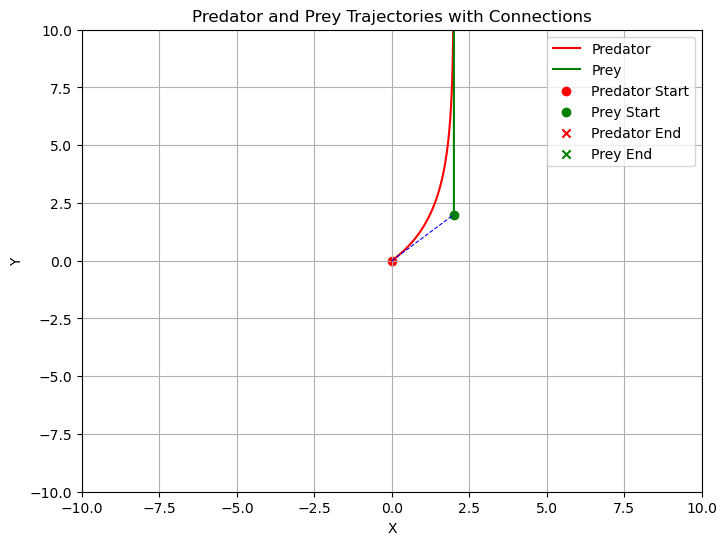

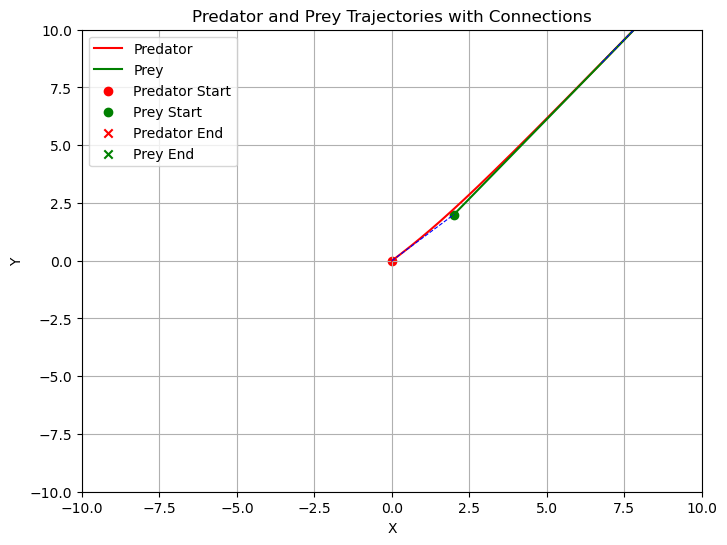

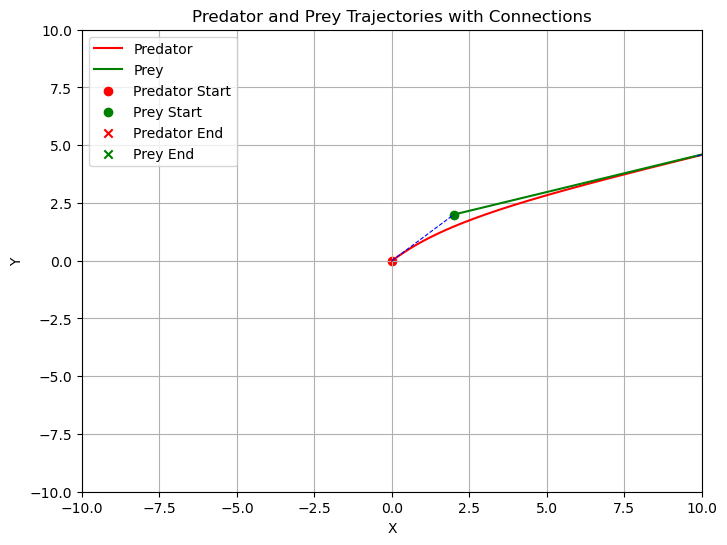

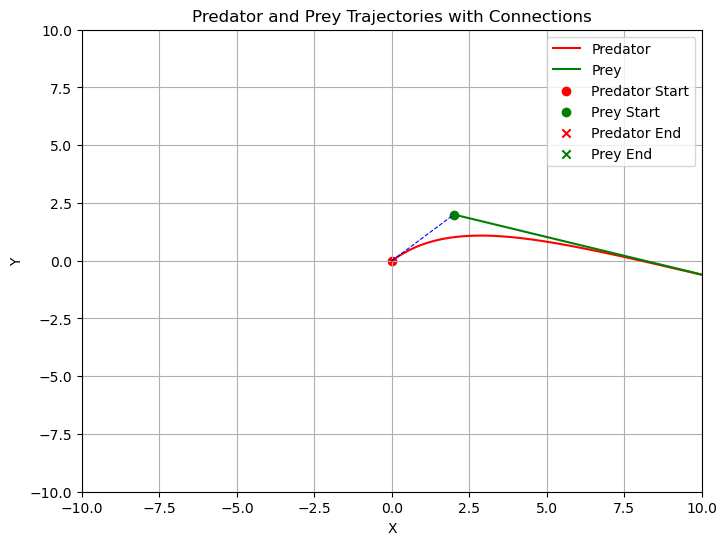

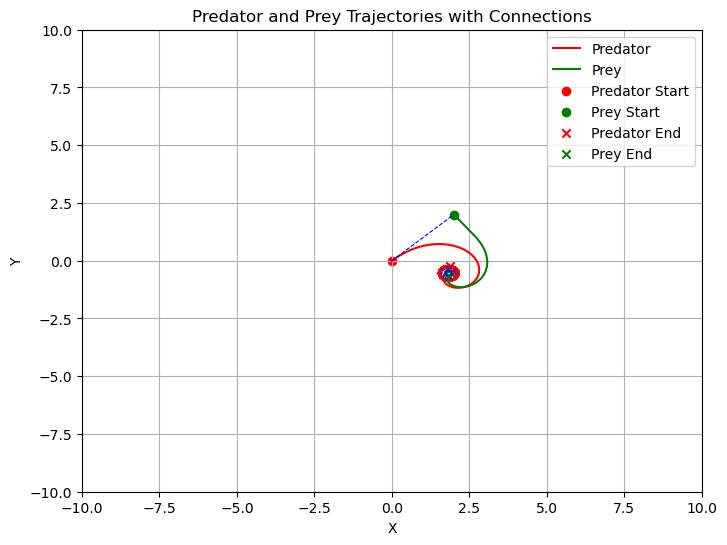

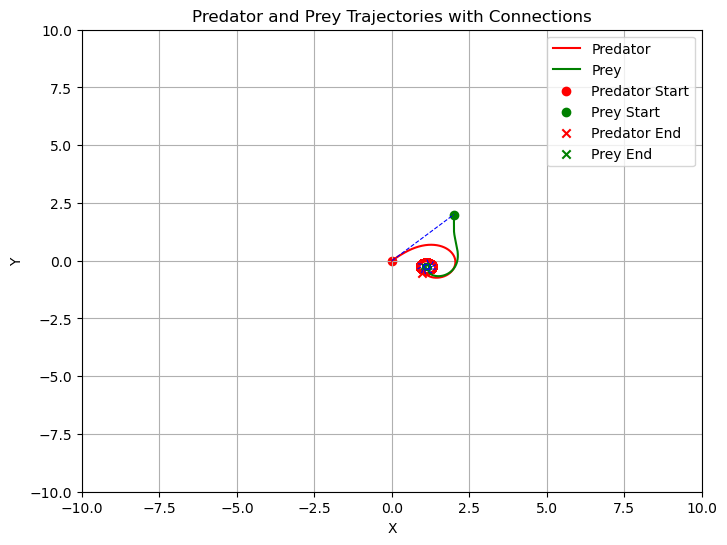

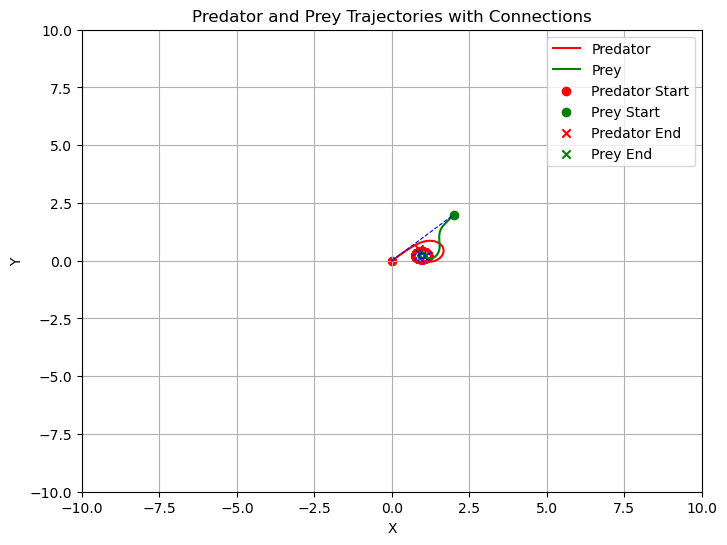

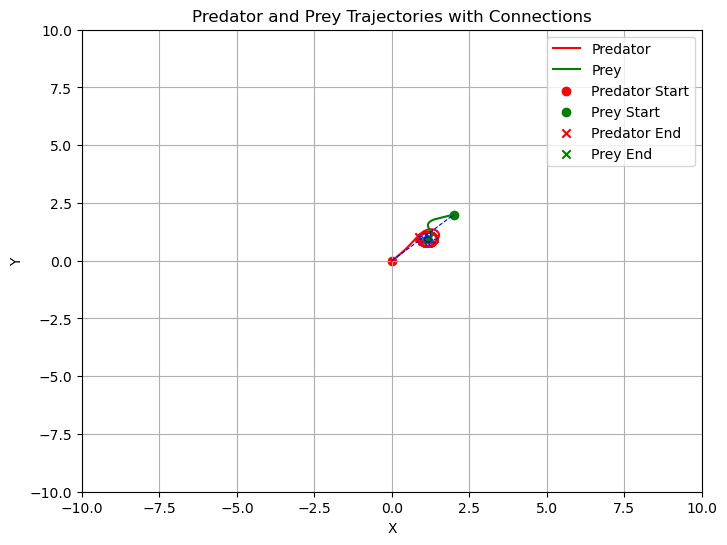

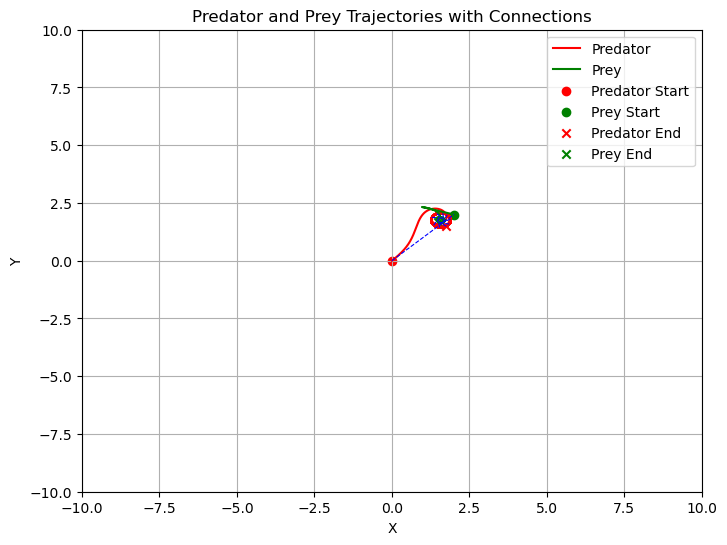

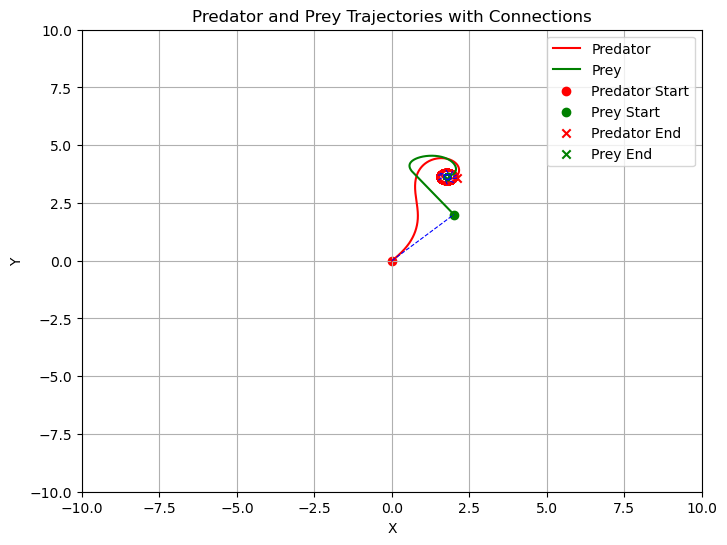

In [ ]:
recordings = []
n = 10
for i in range(n):
    params = {
        "dt": 0.0001,
        
        "x1_max": 1,
        "y1_max": 3,
        
        "x2_max": 3,
        "y2_max": 1,
        
        "R_kill": 0.001,
        "R_react": 2,
    }

    params['n_steps'] = round(100 / params['dt'])
    
    state = get_trajectory(360/n*i)
    simulate(state, params)
    plot_trajectories(state, 10)
    recordings += [state]